In [1]:
#KHAI BÁO THƯ VIỆN
import torch
from torchvision import models,transforms
import os.path as osp
import torch.utils.data as data
from PIL import Image 
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob


c:\Users\DinhManh\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# ĐỊNH DẠNH ẢNH ĐẦU VÀO
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)


In [3]:
# LẤY VÀ ĐƯA CÁC ẢNH VÀO LIST
def make_data_list(phase):
    train_path = osp.join('datasets/' + phase + '/*/*.jpg')
    path_list = []
    for path in glob.glob(train_path):
        path_list.append(path)
    return path_list


In [4]:
#Số lượng ảnh các loại
train_list = make_data_list('train')
val_list = make_data_list('val')
test_list = make_data_list('test')
print(len(train_list))
print(len(val_list))
print(len(test_list))


3913
1730
150


In [5]:
#Gán nhãn cho các trạng thái
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, id):
        img_path = self.file_list[id]
        img = Image.open(img_path)

        img_tranformed = self.transform(img, self.phase)

        if self.phase == "train":
            label = img_path[15:19]
        elif self.phase == "val":
            label = img_path[13:17]
        if label == "free":
            label = 0
        elif label == "busy":
            label = 1
        return img_tranformed, label
        


In [6]:
resize = (224,224)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = MyDataset(train_list,ImageTransform(resize,mean,std),phase = 'train')
val_dataset = MyDataset(val_list,ImageTransform(resize,mean,std),phase='val')
print(train_dataset)
print(val_dataset)

In [7]:
img, label = val_dataset.__getitem__(0)
print(img.shape,label)

torch.Size([3, 224, 224]) 1


In [8]:
#SET SỐ LƯỢNG ẢNH MỖI LẦN ĐƯA VÀO
batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size,shuffle=True)

In [9]:
dataload_dict = {"train":train_dataloader,"val":val_dataloader}
batch_iter= iter(dataload_dict["val"])
inputs , labels = next(batch_iter)

In [10]:
print(inputs.shape)
print(labels)

torch.Size([10, 3, 224, 224])
tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 1])


In [26]:
#TẠO MODEL
class Cnn(nn.Module):
  def __init__(self):
    super(Cnn,self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
    self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.fc1 = nn.Linear(3*3*64,10)
    self.fc2 = nn.Linear(10,2)
    self.relu = nn.ReLU()
        
  def forward(self,x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.view(out.size(0),-1)
      out = self.relu(self.fc1(out))
      out = self.fc2(out)
      return out

In [27]:
model = Cnn()
print(model)

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
)


In [13]:
# XÂY DỰNG HÀM TRAIN MODEL
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
save_path = 'model.pth'

In [28]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epochs):
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs):
        print("Epoch{}-{}".format(epoch, num_epochs))

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

            if(epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double(
            ) / len(dataloader_dict[phase].dataset)
            train_losses.append(epoch_loss)
            valid_losses.append(epoch_accuracy)

            print("{} Loss:{:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_accuracy))
    torch.save(model.state_dict(), save_path)
    return train_losses, valid_losses
#Hộp rỗng

In [ ]:
#BẮT ĐẦU TRAIN
num_epoch = 10
train_losses,valid_losses = train_model(model,dataload_dict,criterion,optimizer,num_epoch)

In [17]:
#ĐỒ THỊ ĐÁNH GIÁ LOSS VÀ ACCURACY

# plt.plot(train_losses, label='Training loss')
# plt.plot(valid_losses, label='Validation loss')
# plt.legend(frameon=False)

In [29]:
# VIẾT HÀM ĐƯA GIÁ TRỊ DỰ DOÁN KHI ĐƯA ẢNH TEST VÀO

def load_model(model,save_path):
    load_weights = torch.load(save_path)
    model.load_state_dict(load_weights)
    return model

In [30]:
class_index = ["free", "busy"]

class Predictor():
    def __init__(self, class_index):
        self.clas_index = class_index

    def predict_max(self, output):
        max_id = np.argmax(output.detach().numpy())
        predict_label = self.clas_index[max_id]
        return predict_label
        
predictor = Predictor(class_index)


In [31]:
def predict(img):
    model = Cnn()
    model.eval()
    model = load_model(model, save_path)

    transform = ImageTransform(resize, mean, std)
    img = transform(img, phase="test")
    img = img.unsqueeze_(0)

    output = model(img)
    response = predictor.predict_max(output)

    return response

datasets/test/busy/a170320a01cc33171a_0c5.jpg


'busy'

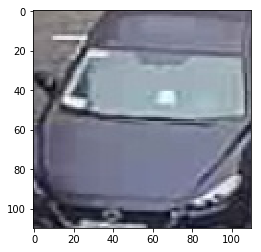

In [36]:
# TEST THỬ 1 ẢNH
Testname_busy = os.listdir('datasets/test/busy')
path = "datasets/test/busy/"+Testname_busy[5]
print(path)
img = Image.open(path)
plt.imshow(img)
predict(img)


datasets/test/free/a170320a01cc33303a_34a3.jpg


'free'

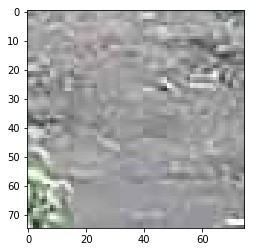

In [34]:
Testname_free=os.listdir('datasets/test/free')
path="datasets/test/free/"+Testname_free[6]
print(path)
img =Image.open(path)
plt.imshow(img)
predict(img)